# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


# setup

In [103]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function
from __future__ import division

# 파이썬2가 파이썬3와 호환되게 함으로써 2개의 버전을 만들지 않게 한다.
# 따라서 모든 파이썬 파일에 다음을 포함시키는 것이 권장사항이다. 
    # from __future__ import absolute_import
    # from __future__ import print_function
    # from __future__ import division
    
# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots # 단위는 inch이다! 모니터의 DPI에 따라 다르게 보임.
plt.rcParams['image.interpolation'] = 'nearest'
# interplocation (보간법) - 이미지를 확대/축소/회전 시 발생하는 hole과 overlap을 처리하는 기법.
plt.rcParams['image.cmap'] = 'gray' # gray인데 WHY COLOR? 
# 예를 들어 'jet'으로 하면 distance 도식화 부분이 화려한 색으로 나오게 된다.
    # 'gray' colormap : 0은 검정색, 1은 흰색
    # 'jet' colormap : 0은 파란색, 1은 빨간색

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# 외부 모듈이 변경되더라도 자동으로 reload하는 기능. 
# ex) knn.ipynb 실행 중간에 k_nearest_neighbor.py 수정한 경우, 이를 다시 import해 주지 않아도 수정 사항을 자동으로 반영해 준다. 
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
    # %autoreload
        # Reload all modules (except those excluded by %aimport) automatically now.
    # %autoreload 0
        # Disable automatic reloading.
    # %autoreload 1
        # Reload all modules imported with %aimport every time before executing the Python code typed.
    # %autoreload 2
        # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 이미지 로딩

## CIFAR-10 Data Loading and Preprocessing

In [104]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


# 이미지 구경하기

# 연습 - np.flatnonzero()

flatnonzero()는 0이 아닌 원소들의 인덱스를 반환

In [105]:
x = np.arange(0,5)
print(x)
x = np.flatnonzero(x)
print(x)

[0 1 2 3 4]
[1 2 3 4]


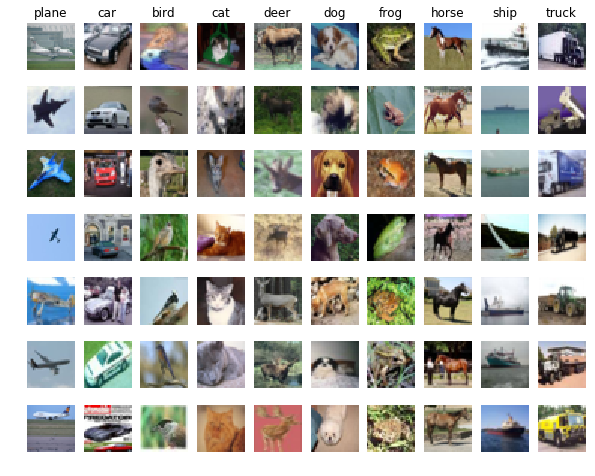

In [106]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

# 첫번째 for loop에서는 각 column당 7개의 랜덤한 이미지를 뽑아주고, 
# 두번째 loop에서 이를 뿌려주고
# 다시 첫번째 loop은 이를 10번 반복한다

for y, cls in enumerate(classes): # 10회 반복. 0 plane -> 1 car -> ... -> 9 truck
    idxs = np.flatnonzero(y_train == y)  # broadcast 통해서 순식간에 50,000번 연산해서 5,000개 뽑아내게 됨
    
    # print (len(idxs)) # 5000
    # print (idxs.shape) # (5000,)
    
    # flatnonzero()는 0이 아닌 원소들의 인덱스를 반환
    # x = np.arange(0,3)
    # x1 = np.flatnonzero(x)
    # print (x1) --> [1 2]
    
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    # 중복 없이 5000개 중 7개를 랜덤하게 뽑는다
    # print (len(idxs)) # 7
    
    # 두번째 for loop에서는 첫번째 loop에서 추출한 column당 7개의 이미지를 뿌려준다
    for i, idx in enumerate(idxs): # 7회 반복. i는 0~6, idx는 인덱스 (ex: 29468 32058 44618 26137 40125 12409  8199)
        plt_idx = i * num_classes + y + 1
        # subplot()에서 위치 지정해 주기 위해 plt_idx 계산 (1,11,...,61 -> 2,12,...,62 -> ... 10,20,...,70)
        plt.subplot(samples_per_class, num_classes, plt_idx)
        # subplot(7,10,1), subplot(7,10,11),...,subplot(7,10,61)
        # subplot(7,10,2), subplot(7,10,12),...,subplot(7,10,62)
        # ...
        # subplot(7,10,10), subplot(7,10,20),...,subplot(7,10,70)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
# plt.show() # 불필요함

# 데이터를 구분해 주자

* training dataset : 49,000개 (원래 학습용 데이터셋 (50,000개) 의 앞부분 49,000개를 떼어내서 사용) 
* validation dataset : 1,000개 (원래 학습용 데이터셋 (50,000개) 의 뒷부분 1,000개를 떼어내서 사용)
* development dataset : 500개 (새로 만든 학습용 데이터셋 (49,000개) 중 랜덤 500개로, 이 새로 만든 학습용 데이터셋과 중복됨)
* test dataset : 1,000개 (원래 테스트용 데이터셋 (10,000개) 의 앞부분 1,000개를 떼어내서 사용)

In [107]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# (1) Validation dataset 정의해 주기
# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# (2) Training dataset 정의해 주기
# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# (3) Development dataset 정의해 주기 - 목적 : loss 시작 시 gradient check 해 주기 (클래스의 개수 - 1 = 9가 되어야 함)
# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# (4) Test dataset 정의해 주기
# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape) # (49000, 32, 32, 3)
print('Train labels shape: ', y_train.shape) # (49000,)
print('Validation data shape: ', X_val.shape) # (1000, 32, 32, 3)
print('Validation labels shape: ', y_val.shape) # (1000,)
print('Test data shape: ', X_test.shape) # (1000, 32, 32, 3)
print('Test labels shape: ', y_test.shape) # (1000,)
print('Development data shape: ', X_dev.shape) # (500, 32, 32, 3)
print('Development labels shape: ', y_dev.shape) # 500,)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Development data shape:  (500, 32, 32, 3)
Development labels shape:  (500,)


# 데이터 전처리 1. 차원 조절

Vectorized 연산을 하기 위해 현재 rank4인 X_train과 X_test를 rank2로 만들어 준다
* X_train : (49000, 32x32x3) == (49000, 3072)
* X_val : (1000, 32x32x3) == (1000, 3072)
* X_test  : (1000, 32x32x3) == (1000, 3072)
* X_dev : (500, 32x32x3) == (500, 3072)

In [108]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


# 데이터 전처리 2. Zero-centered (1) image mean 구하기

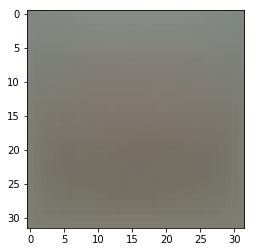

In [109]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0) # (3072,) # 32x32x3 (=3072) 각각의 픽셀에 대한 평균값을 구해 준다
# print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
# plt.show() # 필요 없음

# 데이터 전처리 2. Zero-centered (2) mean image  빼주기

In [110]:
# second: subtract the mean image from train and test data
X_train -= mean_image # (49000, 3072) 에서 (3072,)를 빼니까 49,000회 반복
X_val -= mean_image   # (1000, 3072) 에서 (3072,)를 빼니까 1,000회 반복
X_test -= mean_image  # (1000, 3072) 에서 (3072,)를 빼니까 1,000회 반복
X_dev -= mean_image   # (500, 3072)  에서 (3072,)를 빼니까 500회 반복

# 데이터 전처리 2. Zero-centered (3) bias trick

In [111]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.

# Bias trick이란 y = wx + b 로 b를 별도로 취급하면 계산이 귀찮으니까 b를 w에 편입시켜 주는 것이다.
# b를 w에 편입시켜주니까 w의 차원이 하나 늘어나고, 이에 따라 자연스럽게 x의 차원도 하나 늘려줘야 한다.
# Lecture note 70 page 참고

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) # (49000,3072)와 (49000,1)을 hstack -> (49000,3073)이 된다
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])       # (1000,3072)와 (1000,1)을 hstack -> (1000, 3073)
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])    # (1000,3072)와 (1000,1)을 hstack -> (1000,3073)
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])       # (500, 3072)와 (500,1)을 hstack -> (500,3073)

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape) # (49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


# SVM Classifier를 이용한 loss와 gradient 구하기

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

## svm_loss_naive() 에서 dW 구하는 방법에 대한 설명

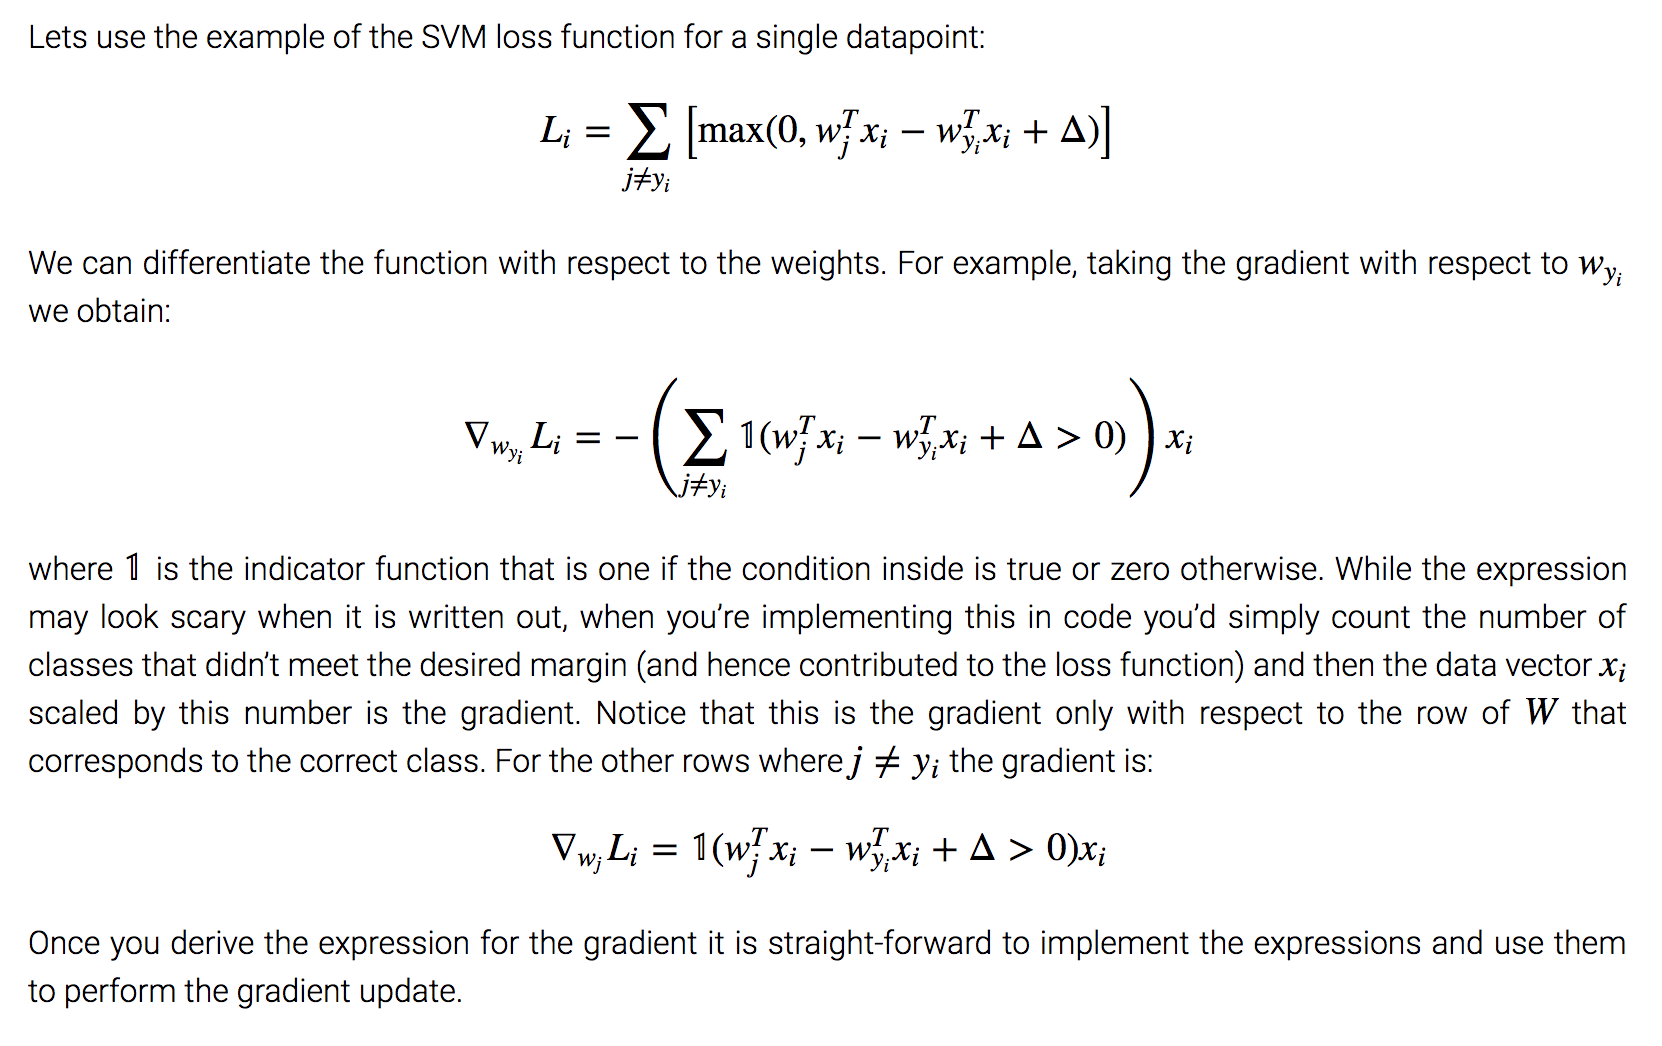

In [25]:
from IPython.display import Image
Image(filename='How_To_Calculate_dW.png')

In [118]:
# Evaluate the naive implementation ofthe loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
# from cs231n.classifiers.linear_svm import svm_loss_vectorized
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 # Bias trick을 썼기 때문에 weight의 차원이 (3073,10) 이 된다. 10은 클래스의 갯수.
# 형규님이 0으로 해보자고 해서 해봤더니 진짜 정확히 9가 나온다!!!! ㅎㅎㅎㅎ하하ㅛ

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
# loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
print('loss: %f' % (loss, )) # Loss에 대한 sanity check : # of classes - 1 = 10 - 1 = 9 와 매우 유사한 값이 나와야 한다!

loss: 9.584383


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

# Gradient Check 하기 (numerical gradient vs. analytic gradient)

In [119]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
# grad_check_sparse는 

# Gradient Check #1 (without regularization)

f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0] # [0]이 없으면 tuple 반환하므로 에러. [0]으로 loss를 받는다
grad_numerical = grad_check_sparse(f, W, grad)
# 그냥 grad_check_sparse(f, W, grad) 로 해도 무방 (리턴값이 없음)


# Gradient Check #2 (with regularization)
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?

loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)
# 그냥 grad_check_sparse(f, W, grad) 로 해도 무방 (리턴값이 없음)

numerical: 7.089945 analytic: 7.089945, relative error: 2.806196e-11
numerical: -11.407899 analytic: -11.315592, relative error: 4.062204e-03
numerical: -31.285200 analytic: -31.285200, relative error: 4.784067e-12
numerical: -17.001338 analytic: -17.001338, relative error: 1.439018e-11
numerical: -18.149623 analytic: -18.149623, relative error: 1.327940e-11
numerical: -16.192376 analytic: -16.192376, relative error: 2.754430e-12
numerical: 15.088266 analytic: 15.088266, relative error: 3.472535e-12
numerical: 24.312850 analytic: 24.312850, relative error: 2.140657e-12
numerical: -15.033546 analytic: -15.033546, relative error: 2.954024e-11
numerical: 14.418488 analytic: 14.418488, relative error: 1.121076e-11
numerical: 10.779515 analytic: 10.778310, relative error: 5.589745e-05
numerical: 6.558661 analytic: 6.561790, relative error: 2.384682e-04
numerical: 18.615687 analytic: 18.615196, relative error: 1.319098e-05
numerical: 15.000318 analytic: 15.004328, relative error: 1.336617e-0

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** We can't differentiate a function at discontinuities. SVM is not continuous at the class margins, so gradient check could fail when the correct class score is higher than the incorrect class by exactly the SVM margin ($\Delta$)

# svm_loss_naive와 svm_loss_vectorized 간에 loss 동일 여부 확인 (+시간 측정)
Loss는 스칼라값이므로 그냥 빼기해서 비교해 주면 된다.

In [120]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.584383e+00 computed in 0.180076s
Vectorized loss: 9.584383e+00 computed in 0.007629s
difference: 0.000000


# svm_loss_naive와 svm_loss_vectorized 간에 gradient 동일 여부 확인 (+시간 측정)
Gradient는 행렬이므로 Frobenius Norm을 이용해 비교해 준다.

In [121]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.209859s
Vectorized loss and gradient: computed in 0.005525s
difference: 0.000000


# SGD를 활용한 Optimization

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [122]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 783.668061
iteration 100 / 1500: loss 469.177154
iteration 200 / 1500: loss 284.135797
iteration 300 / 1500: loss 172.745553
iteration 400 / 1500: loss 106.143960
iteration 500 / 1500: loss 65.464168
iteration 600 / 1500: loss 41.494000
iteration 700 / 1500: loss 27.817318
iteration 800 / 1500: loss 18.031319
iteration 900 / 1500: loss 13.805560
iteration 1000 / 1500: loss 11.054678
iteration 1100 / 1500: loss 8.672439
iteration 1200 / 1500: loss 7.254241
iteration 1300 / 1500: loss 6.238371
iteration 1400 / 1500: loss 5.859620
That took 7.722500s


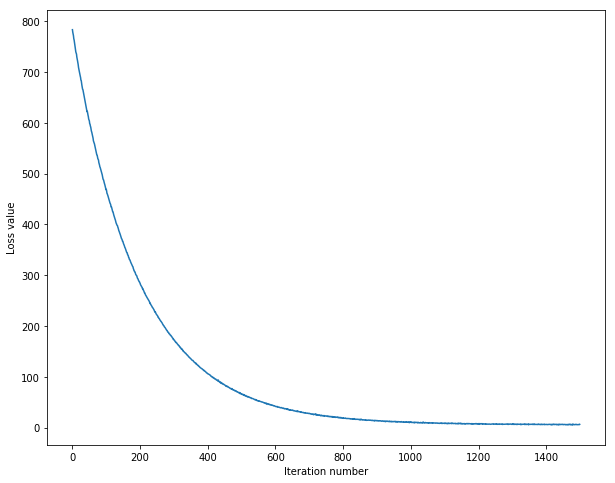

In [123]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [124]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.381837
validation accuracy: 0.386000


# Hyperparameter 튜닝
* Learning rate
* Lambda (Regularization strength)

## 총 4가지 조합 (learning rate 2개, lambda 2개) 비교

이때의 최고 정확도 : 38.4%

In [125]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# 총 4회 loops
for learning_rate in learning_rates: # 2 loops (1e-7, 5e-5)
     for reg in regularization_strengths: # 2 loops (25000, 50000) 
        svm = LinearSVM()
        loss = svm.train(X_train, y_train, learning_rate=learning_rate, reg=reg, num_iters=3000, verbose=True)
        # loss = svm.train(X_train, y_train, learning_rate=learning_rate, reg=reg, num_iters=3000, verbose=False)
        y_train_pred = svm.predict(X_train)
        train_accuracy = (np.mean(y_train == y_train_pred))
        y_val_pred = svm.predict(X_val)
        valid_accuracy = (np.mean(y_val == y_val_pred))
        results[(learning_rate, reg)] = (train_accuracy, valid_accuracy)
        if best_val == None or valid_accuracy > best_val:
            best_val = valid_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results): # sorted() 기준은 lr, reg 순서
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 3000: loss 787.764827
iteration 100 / 3000: loss 467.266167
iteration 200 / 3000: loss 283.853266
iteration 300 / 3000: loss 173.016683
iteration 400 / 3000: loss 105.687846
iteration 500 / 3000: loss 65.535294
iteration 600 / 3000: loss 42.070489
iteration 700 / 3000: loss 27.781239
iteration 800 / 3000: loss 18.741944
iteration 900 / 3000: loss 13.568686
iteration 1000 / 3000: loss 10.210137
iteration 1100 / 3000: loss 9.045950
iteration 1200 / 3000: loss 7.039548
iteration 1300 / 3000: loss 6.366885
iteration 1400 / 3000: loss 6.492045
iteration 1500 / 3000: loss 5.710811
iteration 1600 / 3000: loss 6.063629
iteration 1700 / 3000: loss 5.575330
iteration 1800 / 3000: loss 5.609918
iteration 1900 / 3000: loss 5.432262
iteration 2000 / 3000: loss 5.611013
iteration 2100 / 3000: loss 5.131839
iteration 2200 / 3000: loss 5.555156
iteration 2300 / 3000: loss 5.571601
iteration 2400 / 3000: loss 5.353231
iteration 2500 / 3000: loss 5.419103
iteration 2600 / 3000: loss 5.5868

/Users/andymac/dev/tf_python3/code/cs231n/2017/assignment1/cs231n/classifiers/linear_svm.py:148: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/Users/andymac/dev/tf_python3/code/cs231n/2017/assignment1/cs231n/classifiers/linear_svm.py:148: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 900 / 3000: loss inf
iteration 1000 / 3000: loss inf
iteration 1100 / 3000: loss inf
iteration 1200 / 3000: loss inf
iteration 1300 / 3000: loss inf
iteration 1400 / 3000: loss inf
iteration 1500 / 3000: loss inf
iteration 1600 / 3000: loss inf
iteration 1700 / 3000: loss inf


/Users/andymac/dev/tf_python3/code/cs231n/2017/assignment1/cs231n/classifiers/linear_svm.py:142: RuntimeWarning: overflow encountered in subtract
  margins = (scores.T - correct_class_score + 1).T
/Users/andymac/dev/tf_python3/code/cs231n/2017/assignment1/cs231n/classifiers/linear_svm.py:142: RuntimeWarning: invalid value encountered in subtract
  margins = (scores.T - correct_class_score + 1).T
/Users/andymac/dev/tf_python3/code/cs231n/2017/assignment1/cs231n/classifiers/linear_svm.py:144: RuntimeWarning: invalid value encountered in less
  margins[margins<0] = 0 # negative number is changed to 0
/Users/andymac/dev/tf_python3/code/cs231n/2017/assignment1/cs231n/classifiers/linear_svm.py:164: RuntimeWarning: invalid value encountered in greater
  binary[margins>0] = 1
/Users/andymac/dev/tf_python3/code/cs231n/2017/assignment1/cs231n/classifiers/linear_svm.py:170: RuntimeWarning: overflow encountered in multiply
  dW += reg*W


iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.382041 val accuracy: 0.389000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.369633 val accuracy: 0.383000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.155918 val accuracy: 0.158000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.389000


## 총 400가지 조합 (learning rate 20개, lambda 20개) 비교

이때의 최고 정확도 : 37.5%

In [50]:
best_val = None
best_svm = None
best_lr, best_reg = None, None

# 총 400회 loop
for learning_rate in np.logspace(-8, -6, 20): # 20 loops # np.logspace()는 log 씌운 np.linspace() 라고 생각하면 된다.
     for reg in np.logspace(3.5, 6, 20): # 20 loops
        svm = LinearSVM()
        loss = svm.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=200, verbose=False)
        y_train_pred = svm.predict(X_train)
        train_accuracy = (np.mean(y_train == y_train_pred))
        y_val_pred = svm.predict(X_val)
        valid_accuracy = (np.mean(y_val == y_val_pred))
        results[(learning_rate, reg)] = (train_accuracy, valid_accuracy)
        if best_val == None or valid_accuracy > best_val:
            print ("Found better hyperparameter combination: learning rate = %0.10f, reg = %0.10f, acc = %f"%(learning_rate, reg, valid_accuracy))
            best_val = valid_accuracy
            best_svm = svm
            best_lr, best_reg = learning_rate, reg
print ("Best learning rate = %f, reg = %f"%(best_lr, best_reg))

Found better comb: learning rate = 0.0000000100, reg = 3162.2776601684, acc = 0.159000
Found better comb: learning rate = 0.0000000100, reg = 5796.3939533850, acc = 0.179000
Found better comb: learning rate = 0.0000000100, reg = 1000000.0000000000, acc = 0.212000
Found better comb: learning rate = 0.0000000127, reg = 545559.4781168514, acc = 0.213000
Found better comb: learning rate = 0.0000000127, reg = 738619.9822079359, acc = 0.238000
Found better comb: learning rate = 0.0000000127, reg = 1000000.0000000000, acc = 0.278000
Found better comb: learning rate = 0.0000000162, reg = 738619.9822079359, acc = 0.285000
Found better comb: learning rate = 0.0000000162, reg = 1000000.0000000000, acc = 0.303000
Found better comb: learning rate = 0.0000000207, reg = 738619.9822079359, acc = 0.307000
Found better comb: learning rate = 0.0000000264, reg = 545559.4781168514, acc = 0.328000
Found better comb: learning rate = 0.0000000336, reg = 402961.1320200396, acc = 0.356000
Found better comb: lea

In [126]:
print ("Best learning rate = %0.9f, reg = %0.9f"%(best_lr, best_reg))

Best learning rate = 0.000000379, reg = 48329.302385718


In [53]:
svm = LinearSVM()
tic = time.time()
loss = svm.train(X_train, y_train, learning_rate=best_lr, reg=best_reg,
                      num_iters=100000, verbose=True)
toc = time.time()
print('It took %fs' % (toc - tic))

iteration 0 / 100000: loss 1474.570312
iteration 100 / 100000: loss 40.864992
iteration 200 / 100000: loss 6.528230
iteration 300 / 100000: loss 5.728943
iteration 400 / 100000: loss 5.731278
iteration 500 / 100000: loss 6.529666
iteration 600 / 100000: loss 6.095659
iteration 700 / 100000: loss 5.350051
iteration 800 / 100000: loss 6.157869
iteration 900 / 100000: loss 6.188603
iteration 1000 / 100000: loss 5.834045
iteration 1100 / 100000: loss 5.957395
iteration 1200 / 100000: loss 5.623080
iteration 1300 / 100000: loss 5.700234
iteration 1400 / 100000: loss 6.104794
iteration 1500 / 100000: loss 5.790874
iteration 1600 / 100000: loss 6.299635
iteration 1700 / 100000: loss 6.295462
iteration 1800 / 100000: loss 6.334347
iteration 1900 / 100000: loss 6.261651
iteration 2000 / 100000: loss 6.205835
iteration 2100 / 100000: loss 5.979608
iteration 2200 / 100000: loss 6.174373
iteration 2300 / 100000: loss 6.102474
iteration 2400 / 100000: loss 6.307457
iteration 2500 / 100000: loss 5.5

iteration 20800 / 100000: loss 6.229208
iteration 20900 / 100000: loss 6.623865
iteration 21000 / 100000: loss 5.583175
iteration 21100 / 100000: loss 6.405223
iteration 21200 / 100000: loss 6.269011
iteration 21300 / 100000: loss 5.884158
iteration 21400 / 100000: loss 6.025817
iteration 21500 / 100000: loss 6.306779
iteration 21600 / 100000: loss 4.908332
iteration 21700 / 100000: loss 6.394261
iteration 21800 / 100000: loss 5.784629
iteration 21900 / 100000: loss 5.852298
iteration 22000 / 100000: loss 5.885807
iteration 22100 / 100000: loss 6.009942
iteration 22200 / 100000: loss 5.708994
iteration 22300 / 100000: loss 6.010385
iteration 22400 / 100000: loss 6.453019
iteration 22500 / 100000: loss 5.745498
iteration 22600 / 100000: loss 6.681050
iteration 22700 / 100000: loss 6.007085
iteration 22800 / 100000: loss 5.922779
iteration 22900 / 100000: loss 6.367859
iteration 23000 / 100000: loss 5.799513
iteration 23100 / 100000: loss 6.155224
iteration 23200 / 100000: loss 5.671259


iteration 41300 / 100000: loss 6.154332
iteration 41400 / 100000: loss 5.979615
iteration 41500 / 100000: loss 5.922607
iteration 41600 / 100000: loss 6.266602
iteration 41700 / 100000: loss 6.057072
iteration 41800 / 100000: loss 6.207343
iteration 41900 / 100000: loss 5.448897
iteration 42000 / 100000: loss 5.673941
iteration 42100 / 100000: loss 5.864736
iteration 42200 / 100000: loss 5.552980
iteration 42300 / 100000: loss 6.005864
iteration 42400 / 100000: loss 6.545180
iteration 42500 / 100000: loss 5.527398
iteration 42600 / 100000: loss 5.740192
iteration 42700 / 100000: loss 5.831647
iteration 42800 / 100000: loss 6.285344
iteration 42900 / 100000: loss 5.775939
iteration 43000 / 100000: loss 5.381100
iteration 43100 / 100000: loss 5.977388
iteration 43200 / 100000: loss 6.430433
iteration 43300 / 100000: loss 6.732230
iteration 43400 / 100000: loss 5.321156
iteration 43500 / 100000: loss 6.422714
iteration 43600 / 100000: loss 5.889683
iteration 43700 / 100000: loss 6.356336


iteration 61800 / 100000: loss 5.859738
iteration 61900 / 100000: loss 6.600780
iteration 62000 / 100000: loss 6.168151
iteration 62100 / 100000: loss 5.672371
iteration 62200 / 100000: loss 5.706299
iteration 62300 / 100000: loss 6.425023
iteration 62400 / 100000: loss 6.187311
iteration 62500 / 100000: loss 5.474146
iteration 62600 / 100000: loss 6.065467
iteration 62700 / 100000: loss 6.239498
iteration 62800 / 100000: loss 6.036945
iteration 62900 / 100000: loss 6.057212
iteration 63000 / 100000: loss 5.876115
iteration 63100 / 100000: loss 6.097391
iteration 63200 / 100000: loss 6.161242
iteration 63300 / 100000: loss 5.590560
iteration 63400 / 100000: loss 5.908045
iteration 63500 / 100000: loss 5.851277
iteration 63600 / 100000: loss 6.730141
iteration 63700 / 100000: loss 5.859693
iteration 63800 / 100000: loss 6.700240
iteration 63900 / 100000: loss 5.691179
iteration 64000 / 100000: loss 6.167989
iteration 64100 / 100000: loss 6.331345
iteration 64200 / 100000: loss 6.324611


iteration 82300 / 100000: loss 6.340142
iteration 82400 / 100000: loss 5.941282
iteration 82500 / 100000: loss 5.421684
iteration 82600 / 100000: loss 6.037091
iteration 82700 / 100000: loss 5.431743
iteration 82800 / 100000: loss 6.520534
iteration 82900 / 100000: loss 5.930081
iteration 83000 / 100000: loss 5.404659
iteration 83100 / 100000: loss 6.094424
iteration 83200 / 100000: loss 6.194421
iteration 83300 / 100000: loss 6.195697
iteration 83400 / 100000: loss 6.214529
iteration 83500 / 100000: loss 6.388300
iteration 83600 / 100000: loss 6.170885
iteration 83700 / 100000: loss 6.736006
iteration 83800 / 100000: loss 5.574609
iteration 83900 / 100000: loss 6.605993
iteration 84000 / 100000: loss 6.233103
iteration 84100 / 100000: loss 5.792101
iteration 84200 / 100000: loss 6.397588
iteration 84300 / 100000: loss 6.735544
iteration 84400 / 100000: loss 5.625171
iteration 84500 / 100000: loss 5.495730
iteration 84600 / 100000: loss 6.349515
iteration 84700 / 100000: loss 6.482613


In [127]:
best_svm = svm

In [128]:
y_train_pred = svm.predict(X_train)
train_accuracy = (np.mean(y_train == y_train_pred))
y_val_pred = svm.predict(X_val)
valid_accuracy = (np.mean(y_val == y_val_pred))
print (train_accuracy, valid_accuracy)

0.100265306122 0.087


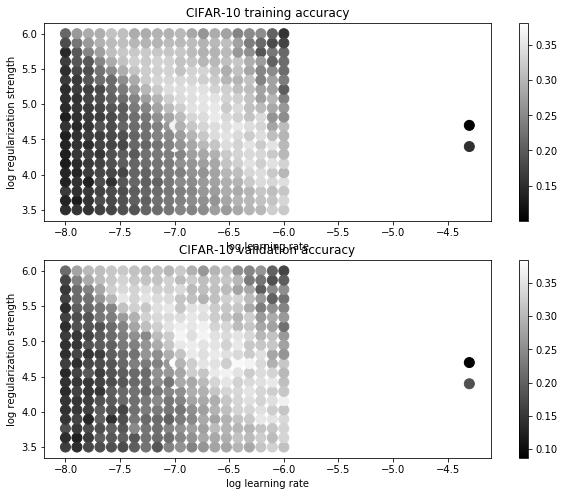

In [59]:
# print (len(results)) # 404 (20 x 20 = 400 인데 왜 404?)
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results] # learning rate
y_scatter = [math.log10(x[1]) for x in results] # regularization strength

# plot training accuracy (위의 그림)

marker_size = 100 # 동그라미 모양의 크기
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar() # 옆의 컬러바
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy (아래 그림)

colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [60]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.357000


# 각각의 클래스에 대해 학습된 가중치를 시각화

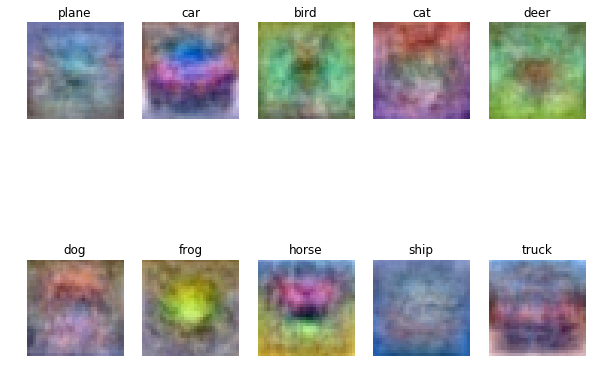

In [81]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias # 마지막 항 (bias) 만 제거
w = w.reshape(32, 32, 3, 10) # 이미지의 형태로 reshape
w_min, w_max = np.min(w), np.max(w) # w_min, w_max 는 스칼라값 (실수))
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    # squeeze()는 1차원의 원소를 제거해 준다 (아래 연습 참고)
    # 하지만 아래처럼, 그냥 안 해줘도 상관 없는 것 같다. 
    # print (w[:,:,:,i].shape) # (32, 32, 3)
    # print (w[:,:,:,i].squeeze().shape) # (32, 32, 3)
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    # print (wimg.shape) # (32, 32, 3)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## 연습 - numpy.squeeze()

특정 차원이 1차원인 경우 없애준다!

In [61]:
x = np.array([[[0], [1], [2]]])
x.shape

(1, 3, 1)

In [62]:
np.squeeze(x).shape

(3,)

In [63]:
np.squeeze(x, axis=0).shape

(3, 1)

In [66]:
np.squeeze(x, axis=1).shape # 1차원이 아니라 3차원이므로 없애주지 못 하고 에러 발생

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [65]:
np.squeeze(x, axis=2).shape

(1, 3)

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** SVM weights for any class, when visualized, looks sort of like an average image of all the training images of that class. SVMs adjusts weights in such a way that separates the correct class score with the incorrect class score by a fixed margin $\Delta$. So, essentially it maximizes the distance between A) the dot product of weights with correct class input values and B) the dot product of the weights with the incorrect class input values. In the process of doing so, these weights pick up some simple but limited characteristic of the input such as spatial location of pixel values and color (in this context color channels are treated the same way as spatial locations). E.g, a car classifier (weights) wants to maximize its output for all car images. If it was the only objective, the weights of the car classifier would look exactly same as mean of the car image as shown below; but it looks different, because the same weights are also responsible for generating the score for other class images that has to have a separation with the correct class score by fixed margine $\Delta$, so the final image is like a trade off between these two constraints.

In [86]:
avg_car = np.mean(X_train[y_train == 1], axis=0) # (3073,)

In [88]:
i_min, i_max = np.min(avg_car), np.max(avg_car) # i_min, i_max는 스칼라 (실수)

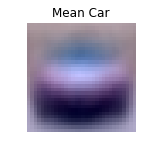

In [84]:
plt.gcf().set_size_inches(2, 2) # get current figure
plt.imshow((avg_car[:-1].reshape(32,32,3).squeeze()-i_min)/(i_max-i_min)) 
# avg_car[:-1]로 bias trick 제거해준 다음에 이미지 형태로 reshape해 준다.
# squeeze() 는 추측건대 여기에서는 필요 없다. 
plt.axis('off')
plt.title("Mean Car")